In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
# torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F
import torch

import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(9)

from google.colab import drive as gdrive
gdrive.mount('/content/drive')
%cp /content/drive/My\ Drive/hw6/data.zip ./
!unzip -qq -u data.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# # notes: -qq不输出过程信息，-u更新
# !unzip -qq -u data.zip
# !ls

# 1. Adversarial Attack

这里的逻辑是这样的：

- 选择一个proxy network（pre_trained）
- 模型预测，若结果正确则进行攻击
- 可以用当前模型做evaluation，计算攻击成功率和L2指标
- 然后使用Black box模型做预测，查看攻击前后结果，做test evaluation，得到攻击结果。



## 1.1 Preparation

- 读取数据
- 读取预训练模型
- 测试数据

In [0]:
class AtDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        self.transform = transforms.Compose([
                                             transforms.Resize((224, 224), interpolation = 3),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std, inplace = False)
        ])
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        x = self.transform(img)
        return x, labels[idx]
    
    def __len__(self):
        return len(paths)

In [0]:
labels = pd.read_csv('/content/data/labels.csv')['TrueLabel'].to_numpy()
label2name = pd.read_csv('/content/data/categories.csv')['CategoryName'].to_numpy()
images_dir = '/content/data/images'
paths = [os.path.join(images_dir, dir_) for dir_ in sorted(os.listdir(images_dir)) if dir_.endswith('png')]
test_set = AtDataset(paths, labels)
test_loader = DataLoader(test_set)

In [0]:
model = models.vgg16(pretrained=True)

In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 1.2 Attack

这边首先实现fgsm_attack的方法，这个方法是普通attack方法的简化版，利用梯度，一步到位。

- 前向传播，计算loss
- 反向传播
- $x^{*} \leftarrow x^{0}-\varepsilon \Delta x$

notes: nll_loss，示例代码中用到了这个损失函数，这个其实是很简单one-hot(label) x activation。cross_entropy_loss中用到了softmax， log，nll_loss。我也不知道为什么只用nll_loss即可。

In [0]:
class AtDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        self.transform = transforms.Compose([
                                             transforms.Resize((224, 224), interpolation = 3),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std, inplace = False)
        ])
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        x = self.transform(img)
        return x, labels[idx]
    
    def __len__(self):
        return len(paths)

In [0]:
def attack(model, loader, epsilon):
    model.eval()
    fail_attacted =0 # 攻击后仍然预测正确，即攻击失败
    correct = 0        # 攻击前预测正确
    imgs_att = []
    img = []
    for tx,ty in loader:
        tx,ty = tx.cuda(), ty.cuda()
        tx.requires_grad = True
        pred = model(tx)
        pred_label = pred.max(1)[1]
        # 预测错误，则不需要进行攻击
        if pred_label.item() != ty.item():
            imgs_att.append(tx.detach().cpu())
            continue
        correct += 1
        # notes: optimizer.zero_grad() 因为一个batch的loss关于weight的导数是所有sample的loss关于weight的导数的累加和
        # 攻击
        model.zero_grad()
        loss = F.nll_loss(pred, ty)
        loss.backward()
        grad = tx.grad.cpu()
        tx_new = tx.cpu() + epsilon * grad.sign()
        # 攻击后预测结果
        pred = model(tx_new.to(device))
        pred_label = pred.max(1)[1]
        if pred_label.item() == ty.item(): # 攻击失败
            fail_attacted += 1
        # 保存攻击结果
        imgs_att.append(tx_new.detach().cpu())
    print("Before attacking, acc is {}%".format(correct / len(test_set)))
    print("After attacking, acc is {}%".format(fail_attacted / len(test_set)))
    imgs_att = torch.cat(imgs_att)
    return imgs_att

In [0]:
device = torch.device('cuda')
model = models.vgg16(pretrained=True).to(device)

In [0]:
epsilon = 0.1
data_set = AtDataset(paths, labels)
loader = DataLoader(test_set, batch_size=1, shuffle=False) # 考虑到本身错误标签不用任何操作，所以这里一个一个调整
data_att = attack(model, loader, epsilon)

Before attacking, acc is 0.865%
After attacking, acc is 0.03%


## 1.3 Evaluation

在其他模型上测试攻击结果。

In [0]:
class EvaluDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, idx):
        x = self.data[idx]
        return x, self.labels[idx]
    
    def __len__(self):
        return len(self.data)

In [0]:
class Evaluator:
    def __init__(self):
        self.black_boxes = [
                            models.vgg16(pretrained=True),
                            models.vgg19(pretrained=True),
                            models.resnet50(pretrained=True),
                            models.resnet101(pretrained=True),
                            models.densenet121(pretrained=True),
                            models.densenet169(pretrained=True)
        ]
    
    def evaluate_all(self, loader):

        accs = []
        for model in self.black_boxes:
            acc = self.evaluate(model, loader)
            accs.append(acc)
            print(acc)
        return accs

    def evaluate(self, model, loader):
        # evaluation
        device = torch.device('cuda')
        model.to(device)
        model.eval()
        acc = 0
        # notes: 测试的时候，防止显存不足，加上no_grad
        with torch.no_grad():
            for x_batch, y_batch in loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                acc += np.sum(np.argmax(pred.detach().cpu().numpy(), axis = 1) == y_batch.cpu().numpy())
        acc = acc / len(data_att)
        return acc

## 1.4 All model baseline


In [0]:
class AtDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        self.transform = transforms.Compose([
                                             transforms.Resize((224, 224), interpolation = 3),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std, inplace = False)
        ])
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        x = self.transform(img)
        return x, labels[idx]
    
    def __len__(self):
        return len(self.paths)
class AtDataset(Dataset):
    # 非懒加载
    def __init__(self, paths, labels):
        self.labels = labels
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transform = transforms.Compose([
                                             transforms.Resize((224, 224), interpolation = 3),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std, inplace = False)
        ])
        self.data = []
        for p in paths:
            img = Image.open(p)
            x = transform(img)
            self.data.append(x[np.newaxis, :])
        self.data = np.concatenate(self.data)
    def __getitem__(self, idx):
        return self.data[idx], labels[idx]
    
    def __len__(self):
        return len(self.labels)
class EvaluDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, idx):
        x = self.data[idx]
        return x, self.labels[idx]
    
    def __len__(self):
        return len(self.data)

def attack(model, loader, epsilon):
    model.eval()
    fail_attacted =0 # 攻击后仍然预测正确，即攻击失败
    correct = 0        # 攻击前预测正确
    num = 0
    imgs_att = []
    img = []
    for tx,ty in loader:
        num += 1
        tx,ty = tx.cuda(), ty.cuda()
        tx.requires_grad = True
        pred = model(tx)
        pred_label = pred.max(1)[1]
        # 预测错误，则不需要进行攻击
        if pred_label.item() != ty.item():
            imgs_att.append(tx.detach().cpu())
            continue
        correct += 1
        # notes: optimizer.zero_grad() 因为一个batch的loss关于weight的导数是所有sample的loss关于weight的导数的累加和
        # 攻击
        model.zero_grad()
        # loss = F.nll_loss(pred, ty)
        loss = F.cross_entropy(pred, ty)
        loss.backward()
        grad = tx.grad.cpu()
        tx_new = tx.cpu() + epsilon * grad.sign()
        # 攻击后预测结果
        pred = model(tx_new.to(device))
        pred_label = pred.max(1)[1]
        if pred_label.item() == ty.item(): # 攻击失败
            fail_attacted += 1
        # 保存攻击结果
        imgs_att.append(tx_new.detach().cpu())
    print("Before attacking, acc is {}%".format(correct / num))
    print("After attacking, acc is {}%".format(fail_attacted / num))
    imgs_att = torch.cat(imgs_att)
    return imgs_att

class Evaluator:
    def __init__(self):
        self.black_boxes = [
                            models.vgg16(pretrained=True),
                            models.vgg19(pretrained=True),
                            models.resnet50(pretrained=True),
                            models.resnet101(pretrained=True),
                            models.densenet121(pretrained=True),
                            models.densenet169(pretrained=True)

        ]
        self.names = ['vgg16', 'vgg19', 'resnet50', 'resnet101', 'densenet121', 'densenet169']

    def evaluate_attack_function(self, attack_func, data_loader, epsilon):
        acc_dict = {}
        att_list = []
        # 攻击测试
        for name,proxy_model in  zip(self.names, self.black_boxes):
            print(name)
            # 攻击
            data_att = attack_func(proxy_model.to(device), data_loader, epsilon)
            att_list.append(data_att)
            # 在所有黑箱模型上验证
            att_set = EvaluDataset(data_att,  labels)
            loader = DataLoader(att_set, batch_size=16, shuffle=False)
            acc = self.evaluate_all(loader)
            # 记录
            acc_dict[name+'(proxy)'] = acc
        # 代理模型acc，及l-inf-norm
        accs = []
        l_infs = []
        for proxy_model, data_att in zip(self.black_boxes, att_list):
            accs.append(self.evaluate(proxy_model, data_loader))
            l_infs.append(self.cal_l_inf_norm(data_att))
        proxy_df = pd.DataFrame({
            'acc':accs,
            'l_inf': l_infs
        })
        proxy_df.index = self.names
        proxy_df = proxy_df.transpose()
        att_df = pd.DataFrame(acc_dict)
        att_df.index = self.names
        
        return proxy_df, att_df

    def evaluate_all(self, loader):

        accs = []
        for model in self.black_boxes:
            acc = self.evaluate(model, loader)
            accs.append(acc)
        return accs

    def evaluate(self, model, loader):
        # evaluation
        device = torch.device('cuda')
        model.to(device)
        model.eval()
        acc = 0
        num = 0
        # notes: 测试的时候，防止显存不足，加上no_grad
        with torch.no_grad():
            for x_batch, y_batch in loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                acc += np.sum(np.argmax(pred.detach().cpu().numpy(), axis = 1) == y_batch.cpu().numpy())
                num += len(y_batch)
        acc = acc / num
        return acc

    def cal_l_inf_norm(self, data_att):
        # imgs_original is a global value
        imgs = imgs_original.astype(np.int32)
        imgs_att = tensor_to_img(data_att).astype(np.int32)
        return np.sum([np.max(diff) for diff in (imgs_att - imgs)])/len(imgs)

    def evaluater_epsilon(self, model, data_loader, epislons):
        acc_dict = {}
        for epsilon in epsilons:
            data_att = attack(model, data_loader, epsilon)
            att_set = EvaluDataset(data_att,  labels)
            loader = DataLoader(att_set, batch_size=16, shuffle=False)
            acc = evaluater.evaluate_all(loader)
            acc.append(np.mean(acc))
            acc.append(evaluater.cal_l_inf_norm(data_att))
            acc_dict[epsilon] = acc

        df = pd.DataFrame(acc_dict)
        df.index  = ['vgg16', 'vgg19', 'resnet50', 'resnet101', 'densenet121', 'densenet169', 'mean', 'l-inf']
        return df

def get_original_imgs(paths):
    transform = transforms.Compose([
                                            transforms.Resize((224, 224), interpolation = 3),
    ])
    data = []
    for p in paths:
        img = Image.open(p)
        x = np.array(transform(img))
        data.append(x[np.newaxis, :])
    data = np.concatenate(data)
    return data

def tensor_to_img(data):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = data.cpu().permute(0, 2, 3, 1).numpy()
    data = np.clip((data * std + mean) * 255, 0, 255)
    data = np.uint8(data)
    return data



labels = pd.read_csv('/content/data/labels.csv')['TrueLabel'].to_numpy()
label2name = pd.read_csv('/content/data/categories.csv')['CategoryName'].to_numpy()
images_dir = '/content/data/images'
paths = [os.path.join(images_dir, dir_) for dir_ in sorted(os.listdir(images_dir)) if dir_.endswith('png')]
device = torch.device('cuda')
evaluater = Evaluator()
imgs_original = get_original_imgs(paths)
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)

In [17]:
# epsilon = 0.1 model = vgg16
model = models.densenet121(pretrained=True).to(device)
epsilons=[0.1]
evaluater.evaluater_epsilon(model, data_loader, epsilons)

Before attacking, acc is 0.925%
After attacking, acc is 0.02%


,0.1
vgg16,0.5500
vgg19,0.5750
resnet50,0.6250
resnet101,0.6650
densenet121,0.0200
densenet169,0.5500
mean,0.4975
l-inf,4.6250


In [16]:
# epsilon = 0.1 model = vgg16
model = models.vgg16(pretrained=True).to(device)
epsilons=[0.1]
evaluater.evaluater_epsilon(model, data_loader, epsilons)

Before attacking, acc is 0.865%
After attacking, acc is 0.015%


,0.1
vgg16,0.015
vgg19,0.345
resnet50,0.720
resnet101,0.770
densenet121,0.705
densenet169,0.715
mean,0.545
l-inf,4.325


In [15]:
# epsilon = 0.1
model = models.resnet50(pretrained=True).to(device)
epsilons=[0.1]
evaluater.evaluater_epsilon(model, data_loader, epsilons)

Before attacking, acc is 1.0%
After attacking, acc is 0.075%


,0.1
vgg16,0.525000
vgg19,0.560000
resnet50,0.075000
resnet101,0.550000
densenet121,0.525000
densenet169,0.595000
mean,0.471667
l-inf,5.000000


In [13]:
# 调节epsilon
model = models.resnet50(pretrained=True).to(device)
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
epsilons = [0.3, 0.4, 0.45, 0.5,0.55, 0.6, 0.65, 0.7]
evaluater.evaluater_epsilon(model, data_loader, epsilons)

Before attacking, acc is 1.0%
After attacking, acc is 0.105%
Before attacking, acc is 1.0%
After attacking, acc is 0.115%
Before attacking, acc is 1.0%
After attacking, acc is 0.11%
Before attacking, acc is 1.0%
After attacking, acc is 0.095%
Before attacking, acc is 1.0%
After attacking, acc is 0.07%
Before attacking, acc is 1.0%
After attacking, acc is 0.06%
Before attacking, acc is 1.0%
After attacking, acc is 0.05%
Before attacking, acc is 1.0%
After attacking, acc is 0.055%


,0.30,0.40,0.45,0.50,0.55,0.60,0.65,0.70
vgg16,0.235000,0.1600,0.135000,0.110000,0.090000,0.075000,0.065000,0.055000
vgg19,0.280000,0.2050,0.155000,0.130000,0.100000,0.060000,0.045000,0.045000
resnet50,0.105000,0.1150,0.110000,0.095000,0.070000,0.060000,0.050000,0.055000
resnet101,0.340000,0.2750,0.240000,0.220000,0.160000,0.140000,0.115000,0.095000
densenet121,0.305000,0.2650,0.245000,0.200000,0.165000,0.160000,0.135000,0.125000
densenet169,0.410000,0.3450,0.310000,0.290000,0.260000,0.220000,0.185000,0.155000
mean,0.279167,0.2275,0.199167,0.174167,0.140833,0.119167,0.099167,0.088333
l-inf,17.000000,23.0000,26.000000,29.000000,32.000000,35.000000,37.000000,40.000000


In [0]:
print(evaluater.evaluate_all(data_loader))

[0.865, 0.87, 1.0, 0.93, 0.925, 0.915]

In [0]:
# epsilon = 0.5 , one_attcak 攻击方法完整测试, 
# best result
epsilon = 0.5

df1, df2 = evaluater.evaluate_attack_function(attack, data_loader, epsilon)
# 可以看到，效果是极佳的，当然了，l-inf可能增加

In [0]:
df1.head()

,vgg16,vgg19,resnet50,resnet101,densenet121,densenet169
acc,0.865,0.87,1.0,0.93,0.925,0.915
l_inf,25.085,25.23,29.0,26.97,26.825,26.535


In [0]:
df2.head()

,vgg16(proxy),vgg19(proxy),resnet50(proxy),resnet101(proxy),densenet121(proxy),densenet169(proxy)
vgg16,0.035,0.135,0.110,0.145,0.100,0.115
vgg19,0.120,0.055,0.130,0.165,0.110,0.150
resnet50,0.350,0.345,0.095,0.205,0.200,0.210
resnet101,0.435,0.465,0.220,0.100,0.260,0.280
densenet121,0.360,0.365,0.200,0.285,0.055,0.200


## 1.5 Iterate fgsm attact

直观的想法就是，epsilon = 0.1的步子太大，考虑把epsilon设置得很小，如果攻击无效，则迭代直至有效。

为了评估这个方法和原来的区别，需要用到L-inf.norm.

结论，效果不好！

 

### 1.5.1 Increases the number of attacks on failed samples

In [0]:
def iterate_fgsm_attack(model, loader, epsilon):
    model.eval()
    fail_attacted =0 # 攻击后仍然预测正确，即攻击失败
    correct = 0        # 攻击前预测正确
    num = 0
    imgs_att = []
    img = []
    max_attack_times = 10000
    accum_attack_times = 0
    for i,(tx,ty) in enumerate(loader):
        num += 1
        tx,ty = tx.to(device), ty.to(device)
        tx.requires_grad = True
        pred = model(tx)
        pred_label = pred.max(1)[1]
        att_times = 0
        # 预测错误，则不需要进行攻击
        while pred_label.item() == ty.item():
            if att_times == max_attack_times:
                break
            att_times += 1
            # notes: optimizer.zero_grad() 因为一个batch的loss关于weight的导数是所有sample的loss关于weight的导数的累加和
            # 攻击
            model.zero_grad()
            # loss = F.nll_loss(pred, ty)
            loss = F.cross_entropy(pred, ty)
            loss.backward()
            grad = tx.grad.cpu()
            tx = tx.cpu() + epsilon * grad.sign()
            tx = torch.tensor(tx.detach().numpy(), requires_grad=True)
            tx.requires_grad = True
            # 攻击后预测结果
            pred = model(tx.to(device))
            pred_label = pred.max(1)[1]
        accum_attack_times += att_times
        # print("case {:3}:  {:3}".format(i, att_times))
            # 保存攻击结果
        imgs_att.append(tx.detach().cpu())
    imgs_att = torch.cat(imgs_att)
    print("总攻击次数， 最大l-inf.norm")
    print(accum_attack_times, accum_attack_times * epsilon * 255 * 0.229 / 200)
    return imgs_att

In [49]:
# epsilon = 0.001 , 
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.0001
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)

att_set = EvaluDataset(data_att,  labels)
loader = DataLoader(att_set, batch_size=16, shuffle=False)
evaluater.evaluate_all(loader)
# 步子微小，对其他模型印象变小，使得对其他模型攻击效果变差，但这个会更少地改变图片

case   0:    4
case   1:    0
case   2:   81
case   3:   22
case   4:   14
case   5:   26
case   6:   70
case   7:    0
case   8:    0
case   9:   19
case  10:  102
case  11:    2
case  12:   17
case  13:    1
case  14:    9
case  15:   51
case  16:   43
case  17:   31
case  18:   27
case  19:   25
case  20:    5
case  21:   18
case  22:   17
case  23:   47
case  24:  142
case  25:   64
case  26:   13
case  27:   35
case  28:   41
case  29:   28
case  30:   55
case  31:   10
case  32:   24
case  33:    0
case  34:    8
case  35:   32
case  36:    1
case  37:   26
case  38:    0
case  39:   20
case  40:   18
case  41:   19
case  42:   23
case  43:   19
case  44:   22
case  45:   25
case  46:    0
case  47:   13
case  48:    2
case  49:    0
case  50:   60
case  51:    6
case  52:   22
case  53:    0
case  54:   34
case  55:   18
case  56:   10
case  57:   26
case  58:    6
case  59:    6
case  60:   37
case  61:   50
case  62:    8
case  63:   30
case  64:   16
case  65:   42
case  66: 

[0.865, 0.87, 0.995, 0.925, 0.0, 0.91]

In [51]:
evaluater.cal_l_inf_norm(data_att)

0.005

In [48]:
# epsilon = 0.001 , 
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.001
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)

att_set = EvaluDataset(data_att,  labels)
loader = DataLoader(att_set, batch_size=16, shuffle=False)
evaluater.evaluate_all(loader)
# 步子微小，对其他模型印象变小，使得对其他模型攻击效果变差，但这个会更少地改变图片

case   0:    1
case   1:    0
case   2:    9
case   3:    3
case   4:    2
case   5:    3
case   6:    8
case   7:    0
case   8:    0
case   9:    2
case  10:   11
case  11:    1
case  12:    2
case  13:    1
case  14:    1
case  15:    6
case  16:    5
case  17:    4
case  18:    3
case  19:    3
case  20:    1
case  21:    2
case  22:    2
case  23:    5
case  24:   15
case  25:    7
case  26:    2
case  27:    4
case  28:    5
case  29:    4
case  30:    7
case  31:    1
case  32:    3
case  33:    0
case  34:    1
case  35:    4
case  36:    1
case  37:    3
case  38:    0
case  39:    3
case  40:    2
case  41:    3
case  42:    3
case  43:    3
case  44:    3
case  45:    3
case  46:    0
case  47:    2
case  48:    1
case  49:    0
case  50:    7
case  51:    1
case  52:    3
case  53:    0
case  54:    4
case  55:    2
case  56:    2
case  57:    3
case  58:    1
case  59:    1
case  60:    6
case  61:    6
case  62:    1
case  63:    4
case  64:    2
case  65:    5
case  66: 

[0.865, 0.87, 0.995, 0.925, 0.0, 0.905]

In [46]:
evaluater.cal_l_inf_norm(data_att)

0.005

In [0]:
# epsilon = 0.1 , 对攻击失败样本攻击次数增加
model = models.vgg16(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)

att_set = EvaluDataset(data_att,  labels)
loader = DataLoader(att_set, batch_size=16, shuffle=False)
evaluater.evaluate_all(loader)
# 从结果来看，vgg19略有提升

In [37]:
# epsilon = 0.01 , 
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.01
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)

att_set = EvaluDataset(data_att,  labels)
loader = DataLoader(att_set, batch_size=16, shuffle=False)
evaluater.evaluate_all(loader)
# 步子微小，对其他模型印象变小，使得对其他模型攻击效果变差，但这个会更少地改变图片

[0.85, 0.845, 0.94, 0.9, 0.0, 0.855]

In [33]:
evaluater.cal_l_inf_norm(data_att)

0.18

In [0]:
# epsilon = 0.01 , 新攻击方法完整测试
model = models.vgg16(pretrained=True).to(device)
epsilon = 0.01
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)

evaluater.evaluate_attack_function(iterate_fgsm_attack, data_loader, epsilon)
# 整体性能微弱提升，首先只针对错误样本是远远不够的。

vgg16
vgg19
resnet50
resnet101
densenet121
densenet169


,vgg16,vgg19,resnet50,resnet101,densenet121,densenet169
vgg16,0.000,0.710,0.825,0.820,0.850,0.825
vgg19,0.750,0.005,0.835,0.850,0.845,0.850
resnet50,0.985,0.975,0.000,0.900,0.940,0.945
resnet101,0.910,0.910,0.850,0.000,0.900,0.885
densenet121,0.915,0.905,0.870,0.885,0.000,0.865
densenet169,0.885,0.885,0.865,0.885,0.855,0.005


### 1.5.2 Increases the number of attacks on whole samples

In [0]:
def iterate_fgsm_multi_attack(model, loader, epsilon):
    model.eval()
    fail_attacted =0 # 攻击后仍然预测正确，即攻击失败
    correct = 0        # 攻击前预测正确
    num = 0
    imgs_att = []
    img = []
    max_attack_times = 20
    for i,(tx,ty) in enumerate(loader):
        num += 1
        tx,ty = tx.to(device), ty.to(device)
        tx.requires_grad = True
        pred = model(tx)
        pred_label = pred.max(1)[1]
        att_times = 0
        # 预测错误，则不需要进行攻击
        while True:
            if att_times == max_attack_times:
                break
            att_times += 1
            # notes: optimizer.zero_grad() 因为一个batch的loss关于weight的导数是所有sample的loss关于weight的导数的累加和
            # 攻击
            model.zero_grad()
            # loss = F.nll_loss(pred, ty)
            loss = F.cross_entropy(pred, ty)
            loss.backward()
            grad = tx.grad.cpu()
            tx = tx.cpu() + epsilon * grad.sign()
            tx = torch.tensor(tx.detach().numpy(), requires_grad=True)
            tx.requires_grad = True
            # 攻击后预测结果
            pred = model(tx.to(device))
            pred_label = pred.max(1)[1]
        # print("case {:3}:  {:3}".format(i, att_times))
            # 保存攻击结果
        imgs_att.append(tx.detach().cpu())
    imgs_att = torch.cat(imgs_att)
    return imgs_att
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)

In [0]:
# epsilon = 0.01 , 新攻击方法完整测试

epsilon = 0.01

evaluater.evaluate_attack_function(iterate_fgsm_attack, data_loader, epsilon)
# 整体性能微弱提升，首先只针对错误样本是远远不够的。

In [0]:
# epsilon = 0.01 , 新攻击方法完整测试, 20个迭代

epsilon = 0.01

evaluater.evaluate_attack_function(iterate_fgsm_attack, data_loader, epsilon)
# 没什么提升，可能是来回跳动

vgg16
vgg19
resnet50
resnet101
densenet121
densenet169


,vgg16,vgg19,resnet50,resnet101,densenet121,densenet169
vgg16,0.005,0.115,0.595,0.680,0.625,0.620
vgg19,0.170,0.005,0.620,0.715,0.650,0.640
resnet50,0.705,0.740,0.000,0.500,0.625,0.630
resnet101,0.765,0.785,0.550,0.000,0.660,0.635
densenet121,0.730,0.750,0.620,0.630,0.000,0.440
densenet169,0.740,0.770,0.660,0.660,0.415,0.015


### 1.5.3 Visualization and L-inf.norm evaluation

L-inf.norm 每个图片之间最大差别和的平均值。
- 得到攻击图片
- 还原图片
- 计算差距

In [0]:
def get_original_imgs():
    transform = transforms.Compose([
                                            transforms.Resize((224, 224), interpolation = 3),
    ])
    data = []
    for p in paths:
        img = Image.open(p)
        x = np.array(transform(img))
        data.append(x[np.newaxis, :])
    data = np.concatenate(data)
    return data
def tensor_to_img(data):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = data.cpu().permute(0, 2, 3, 1).numpy()
    data = np.clip((data * std + mean) * 255, 0, 255)
    data = np.uint8(data)
    return data
def cal_l_inf_norm(data_att, imgs_original):
    imgs_original = get_original_imgs().astype(np.int32)
    imgs_att = tensor_to_img(data_att).astype(np.int32)
    return np.sum([np.max(diff) for diff in (imgs_att - imgs_original)])/len(imgs_original)

In [0]:
epsilon = 0.1
model = models.vgg16(pretrained=True).to(device)


In [0]:
# 获取原图
imgs_original = get_original_imgs()
# imgs_original = tensor_to_img(torch.tensor(data_set.data).to(device))

In [0]:
# 攻击后图片
data_att = attack(model, data_loader, epsilon)
imgs_att = tensor_to_img(data_att).astype(np.int32)

Before attacking, acc is 0.865%
After attacking, acc is 0.015%


In [0]:
cal_l_inf_norm(data_att, imgs_original)

4.325

## 1.6 Normal Attack Method

常规攻击方法，不再是去Δx.sign()，自定义loss函数，优化l-inf值。


## 1.7 Save and submit

保存，遇到一个问题，生成图片反标准化后会出现负值或超过255，正确的解决方式是——clip to （0，255）

In [0]:
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


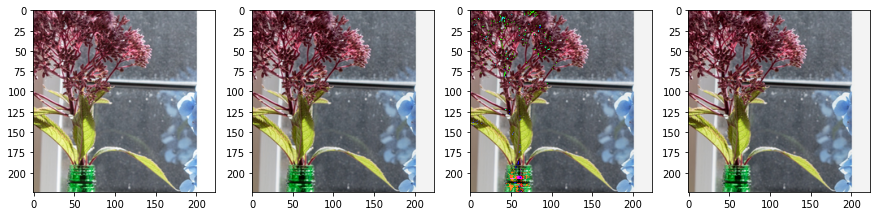

In [0]:
# 原图
img_original = Image.open('/content/data/images/001.png')
# 模拟梯度下降
img = data_set[1][0].permute(1, 2, 0).numpy()-0.2
# 反标准化
img = img * np.array(std) + np.array(mean)
# 直接转为uint8
img_uint = np.uint8(img*255)
# clip [0, 255]
img_rev_clip = np.uint8(np.clip(img*255, 0, 255))
fig, axs = plt.subplots(1, 4, figsize = (15, 15))
axs[0].imshow(img_original)
axs[1].imshow(img)
axs[2].imshow(img_uint)
axs[3].imshow(img_rev_clip)

In [0]:
def tensor_to_img(data):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = data.cpu().permute(0, 2, 3, 1).numpy()
    data = np.clip((data * std + mean) * 255, 0, 255)
    data = np.uint8(data)
    return data
def save_to_imgs(img_arr, output_path = '/content/output'):
    if os.path.exists(output_path) is False:
        os.makedirs(output_path)
    for i, arr in enumerate(img_arr):
        img = Image.fromarray(arr)
        img.save(os.path.join(output_path, '{:03d}.png'.format(i)))

提交记录
- vgg16_0.1 2.9 5.3
- resnet50 4.7 6
- resnet50_0.5 0.795 30 黑箱模型很可能是densenet121
- densenet121_0.1 	0.975	5.6250  就是它
- densenet121_0.01 	0.980	1.1800  最佳结果
- densenet121_0.001 	0.955	1.0300  
-----
- vgg16 
- vgg19
- resnet 101
- densenet169

In [52]:
# epsilon = 0.0001 ,  最大程度减小epsilon，多次攻击
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.001
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)

case   0:    1
case   1:    0
case   2:    9
case   3:    3
case   4:    2
case   5:    3
case   6:    8
case   7:    0
case   8:    0
case   9:    2
case  10:   11
case  11:    1
case  12:    2
case  13:    1
case  14:    1
case  15:    6
case  16:    5
case  17:    4
case  18:    3
case  19:    3
case  20:    1
case  21:    2
case  22:    2
case  23:    5
case  24:   15
case  25:    7
case  26:    2
case  27:    4
case  28:    5
case  29:    4
case  30:    7
case  31:    1
case  32:    3
case  33:    0
case  34:    1
case  35:    4
case  36:    1
case  37:    3
case  38:    0
case  39:    3
case  40:    2
case  41:    3
case  42:    3
case  43:    3
case  44:    3
case  45:    3
case  46:    0
case  47:    2
case  48:    1
case  49:    0
case  50:    7
case  51:    1
case  52:    3
case  53:    0
case  54:    4
case  55:    2
case  56:    2
case  57:    3
case  58:    1
case  59:    1
case  60:    6
case  61:    6
case  62:    1
case  63:    4
case  64:    2
case  65:    5
case  66: 

In [0]:
!rm -rf ./*

In [13]:
# epsilon = 0.01 多次攻击错误对象
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.01
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)

总攻击次数， 最大l-inf.norm
226 0.6598635000000002


In [20]:
# densenet_121 0.1
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)

Before attacking, acc is 0.925%
After attacking, acc is 0.02%


In [0]:
# nll_loss vgg
model = models.vgg16(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)
# 2.9 5.8

Before attacking, acc is 0.865%
After attacking, acc is 0.015%


In [0]:
# cross_entropy vgg
model = models.vgg16(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)

Before attacking, acc is 0.865%
After attacking, acc is 0.015%


In [0]:
# cross_entropy resnet
model = models.resnet50(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)
# 4.7 6

Before attacking, acc is 1.0%
After attacking, acc is 0.075%


In [0]:
# cross_entropy densenet
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.1
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)

Before attacking, acc is 0.925%
After attacking, acc is 0.02%


In [0]:
# cross_entropy resnet
model = models.resnet50(pretrained=True).to(device)
epsilon = 0.5
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)
# 

Before attacking, acc is 1.0%
After attacking, acc is 0.095%


In [0]:
# cross_entropy resnet
model = models.resnet50(pretrained=True).to(device)
epsilon = 0.5
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = attack(model, data_loader, epsilon)
data = tensor_to_img(data_att)
save_to_imgs(data)
# l-inf.norm大于20不通过

In [0]:
%cd ./output/
!tar -zcvf ../output.tgz *.png
!cp /content/output.tgz /content/drive/My\ Drive/hw6/densenet121_0_001.tgz

## 2. 实验

这次的实验在第一部分大部分完成了，终于突破了strong baseline，原因是发现背后的模型了……



- （2%）试说明hw6_best.sh攻击的方法，包括使用的proxy model、方法、参数等。此方法和FGSM的差异为何？如何影响你的结果？请完整讨论。（依内容完整度给分）

- （1%）请尝试不同的proxy model，依照你的实作的结果来看，背后的black box最有可能为哪一个模型？请说明你的观察和理由。

- （1%）请以最好的的方法，visualize任意三张图片攻击前后的机率图（分别取前三高的机率）。

- （2%）请将你产生出来的adversarial img，以任一种smoothing的方式实作被动防御（passive defense），观察是否有效降低模型的误判的比例。请说明你的方法，附上你防御前后的success rate，并简要说明你的观察。另外也请讨论此防御对原始图片会有什么影响。


## 2.1 最佳攻击方法

很简单，没什么可以讲的，最佳的模型选用dense121，epsilon = 0.01，为了防止攻击失败，对于攻击失败的结果进行多次攻击。这个多次攻击模型和FGSM几乎一模一样，但它是攻击不成功不罢休的类型。而这种写法的好处是，如果模型和black box模型一样，那么它可以将epsilon设置得非常小，即尽可能最小化对原图的改变的情况下得到百分之百的攻击成功概率。当然，缺点是，对于其他black box模型效果微弱。

## 2.2 推测black box

主要是从四次提交记录中推测出来的。
- vgg16  分数2.95
- resnet50 分数4.7 6
- densenet121_0.1 	分数9.75	

很明显，black box应该是densenet系列。但其实我一开始根本没有测试densenet，我以为是resnet（太有名，而且结果也挺好，所以一开始先入为主，后期测试resnet50，epsilon = 0.5，对所有模型做测试，发现网站的分数和densenet的结果非常有相关性。如下

- resnet50_0.5 分数0.795

为了验证想法，我试着一开始几次提交的结果做验证。

In [56]:
epsilon = 0.1
df1,df2 = evaluater.evaluate_attack_function(attack, data_loader, epsilon)
# 整体性能微弱提升，首先只针对错误样本是远远不够的。
df2

vgg16
Before attacking, acc is 0.865%
After attacking, acc is 0.015%
vgg19
Before attacking, acc is 0.87%
After attacking, acc is 0.03%
resnet50
Before attacking, acc is 1.0%
After attacking, acc is 0.075%
resnet101
Before attacking, acc is 0.93%
After attacking, acc is 0.065%
densenet121
Before attacking, acc is 0.925%
After attacking, acc is 0.02%
densenet169
Before attacking, acc is 0.915%
After attacking, acc is 0.1%


,vgg16(proxy),vgg19(proxy),resnet50(proxy),resnet101(proxy),densenet121(proxy),densenet169(proxy)
vgg16,0.015,0.315,0.525,0.620,0.550,0.580
vgg19,0.345,0.030,0.560,0.620,0.575,0.630
resnet50,0.720,0.745,0.075,0.545,0.625,0.630
resnet101,0.770,0.765,0.550,0.065,0.665,0.670
densenet121,0.705,0.715,0.525,0.595,0.020,0.525
densenet169,0.715,0.735,0.595,0.645,0.550,0.100


- vgg16  分数2.95, 上表dn121刚好为0.7左右
- resnet50 分数4.7 6，上表dn121刚好为5.3左右
- densenet121_0.1 	分数9.75，上表dn121刚好为0.2左右

因此线上模型应该就是densenet系列，而且很可能就是densenet121

## 2.3 可视化攻击结果

In [0]:
def n_argmax(p, n):
    dict_= dict(zip(range(len(p)), p))
    dict_ = sorted(dict_.items(), key = lambda item: item[1], reverse=True)
    r = []
    r_idxs=[]
    for k,v in dict_:
        r.append(v)
        r_idxs.append(k)
        if len(r) == n:
            break
    return r_idxs, r

In [110]:
model = models.densenet121(pretrained=True).to(device)
epsilon = 0.01
data_set = AtDataset(paths, labels)
data_loader = DataLoader(data_set)
data_att = iterate_fgsm_attack(model, data_loader, epsilon)

总攻击次数， 最大l-inf.norm
226 0.6598635000000002


In [111]:
idxs = np.array([0, 10, 20])
# 攻击后的输入
samples_att = data_att[idxs]
# 攻击前的输入
samples = []
for idx in idxs:
    print(idx)
    samples.append(torch.tensor(data_set[idx][0]).unsqueeze(0))
samples =torch.cat(samples)

0
10
20


In [0]:
model.eval()
with torch.no_grad():
    p_att = F.softmax(model(samples_att.to(device))).cpu().numpy()
    p = F.softmax(model(samples.to(device))).cpu().numpy()

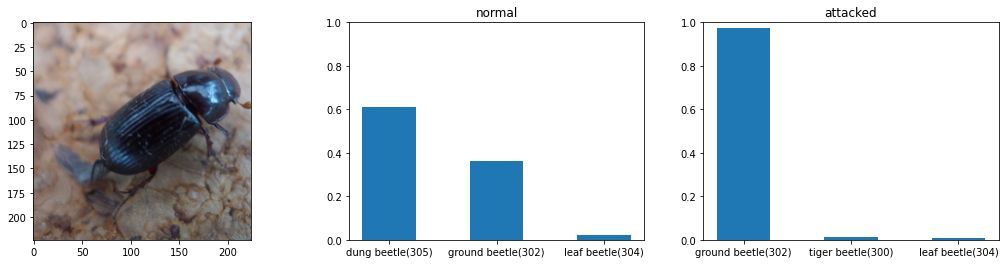

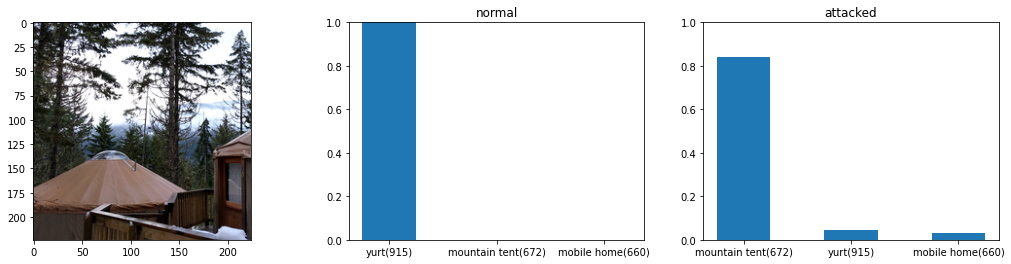

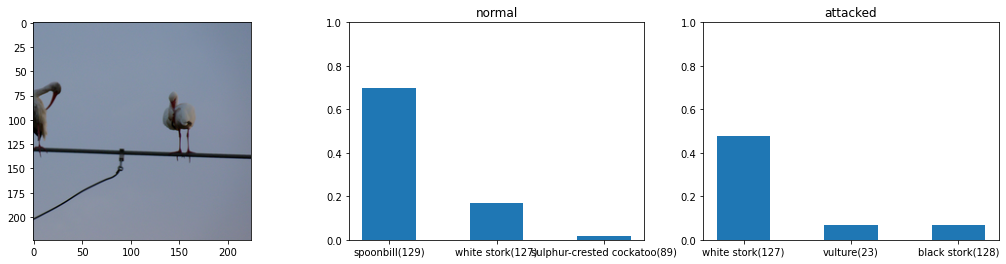

In [113]:
def show_pros(axs, pros, labels, title):
    axs.bar(range(3), pros,width=0.5)
    # axs.set_ylim(0,1)
    axs.set_xticks(range(len(pros)))
    axs.set_xticklabels([label2name[i].split(',')[0] + f'({i})' for i in labels])
    axs.set_title(title)
    axs.set_ylim(0, 1)
for i in range(3):
    labels, pros = n_argmax(p[i], 3)
    labels_att, pros_att = n_argmax(p_att[i], 3)

    fig, axs = plt.subplots(1,3, figsize = (18, 4))
    axs[0].imshow(imgs_original[idxs[i]])
    show_pros(axs[1], pros, labels, 'normal')
    show_pros(axs[2], pros_att, labels_att, 'attacked')
    plt.show()

##2.4  被动防御

随便使用一个smooth策略，观察对结果的影响。

从结果来看，有了一定程度的缓解，但label还是没办法还原。原本confidence越高的，还原越好。

In [116]:
imgs_att = tensor_to_img(samples_att)
smooth_path = '/content/output'
for i, arr in enumerate(imgs_att):
    print(arr.shape)
    img = Image.fromarray(arr)
    img = img.filter(ImageFilter.GaussianBlur)
    img.save(os.path.join(smooth_path, '{:03d}.png'.format(idxs[i])))
smooth_paths = [os.path.join(smooth_path, dir_) for dir_ in sorted(os.listdir(smooth_path)) if dir_.endswith('png')]

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [117]:
smooth_set = AtDataset(smooth_paths, labels)
samples_smooth = []
for idx in idxs:
    print(idx)
    samples_smooth.append(torch.tensor(smooth_set[idx][0]).unsqueeze(0))
samples_smooth =torch.cat(samples_smooth)

0
10
20


In [0]:
model.eval()
with torch.no_grad():
    p_smooth = F.softmax(model(samples_smooth.to(device))).cpu().numpy()


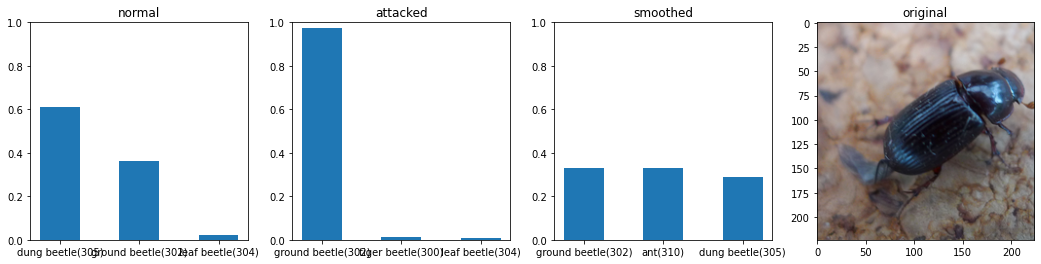

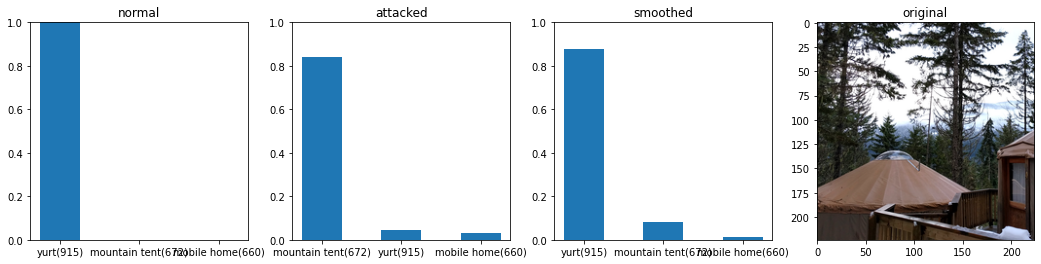

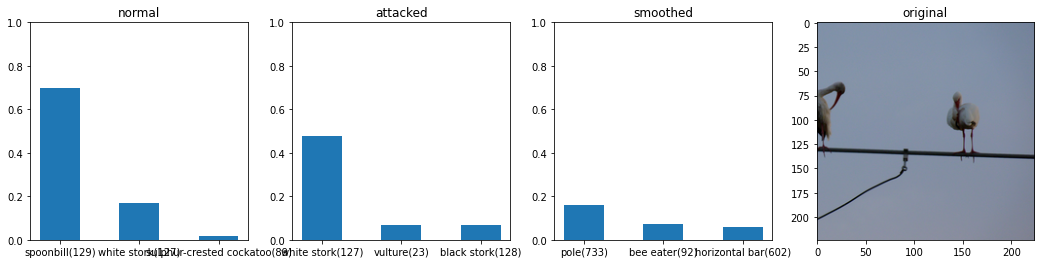

In [119]:
def show_pros(axs, pros, labels, title):
    axs.bar(range(3), pros,width=0.5)
    # axs.set_ylim(0,1)
    axs.set_xticks(range(len(pros)))
    axs.set_xticklabels([label2name[i].split(',')[0] + f'({i})' for i in labels])
    axs.set_title(title)
    axs.set_ylim(0, 1)
for i in range(3):
    labels, pros = n_argmax(p[i], 3)
    labels_att, pros_att = n_argmax(p_att[i], 3)
    labels_smooth, pros_smooth = n_argmax(p_smooth[i], 3)
    fig, axs = plt.subplots(1,4, figsize = (18, 4))
    show_pros(axs[0], pros, labels, 'normal')
    show_pros(axs[1], pros_att, labels_att, 'attacked')
    show_pros(axs[2], pros_smooth, labels_smooth, 'smoothed')
    axs[3].imshow(imgs_original[idxs[i]])
    axs[3].set_title('original')
    plt.show()

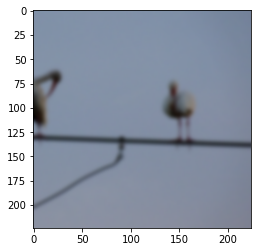

In [120]:
plt.imshow(img)